# Churn Modeling for Customer Retention

**Part 4 of 4 — Retail Customer Intelligence**

Predict who is likely to churn and prioritize retention efforts. This notebook:
- Trains multiple classifiers (Logistic Regression, Random Forest, XGBoost, LightGBM)
- Calibrates probabilities for reliable risk scores
- Optimizes decision thresholds using business cost-benefit analysis
- Evaluates performance with ROC-AUC, PR-AUC, Lift, and Gains curves
- Combines churn risk with CLV to create a **business-driven priority score**
- Generates actionable retention recommendations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Train Features and Churn Labels

Load customer features from notebook 1 and churn labels from the holdout window. Merge them on customer_id and prepare the dataset for modeling.

In [2]:
DATA_DIR = Path(r"d:\Projects\Retail_Customer_Intelligence\data\processed")
MODELS_DIR = Path(r"d:\Projects\Retail_Customer_Intelligence\models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

features = pd.read_csv(DATA_DIR / "customer_features_train.csv", parse_dates=["last_purchase"])
labels = pd.read_csv(DATA_DIR / "customer_churn_labels.csv", parse_dates=["snapshot_date", "train_end"])

churn_df = features.merge(labels[["customer_id", "churned"]], on="customer_id", how="left")
churn_df["churned"] = churn_df["churned"].fillna(0).astype(int)

print(f"Total customers: {len(churn_df):,}")
print(f"Features shape: {churn_df.shape}")
print(f"\nFirst few rows:")
print(churn_df.head())
print(f"\nData types:\n{churn_df.dtypes}")

Total customers: 5,281
Features shape: (5281, 9)

First few rows:
   customer_id  recency_days  frequency_invoices  monetary  avg_order_value  avg_items_per_invoice  active_months       last_purchase  churned
0        12346           235                  12  77556.46      2281.072353            2184.852941              5 2011-01-18 10:01:00        1
1        12347            39                   6   4114.18        21.098359              12.400000              6 2011-08-02 08:48:00        0
2        12348           158                   4   1709.40        35.612500              52.020833              4 2011-04-05 10:47:00        0
3        12349           317                   3   2671.14        26.187647               9.735294              3 2010-10-28 08:23:00        0
4        12350           219                   1    334.40        19.670588              11.588235              1 2011-02-02 16:01:00        1

Data types:
customer_id                       int64
recency_days           

## 2. Exploratory Data Analysis (Churn Distribution)

Calculate churn rate, visualize the distribution of churned vs active customers, and identify class imbalance.

Overall Churn Rate: 56.60%
Churned Customers: 2,989
Active Customers: 2,292


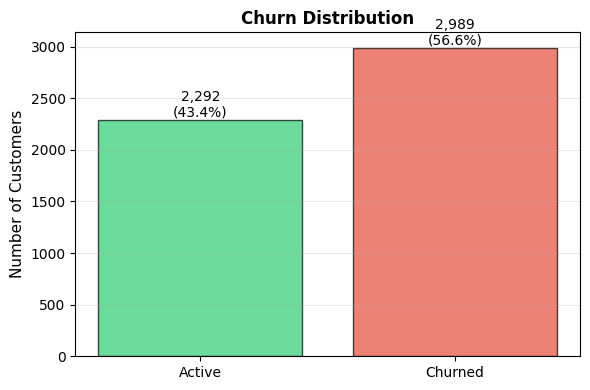


Class Imbalance Ratio: 0.8:1 (Active:Churned)


In [3]:
# Calculate churn rate
churn_rate = churn_df["churned"].mean()
print(f"Overall Churn Rate: {churn_rate:.2%}")
print(f"Churned Customers: {churn_df['churned'].sum():,}")
print(f"Active Customers: {(1 - churn_df['churned']).sum():,}")

# Visualize distribution
fig, ax = plt.subplots(figsize=(6, 4))
churn_counts = churn_df["churned"].value_counts()
labels_plot = ["Active", "Churned"]
colors = ["#2ecc71", "#e74c3c"]
ax.bar(labels_plot, [churn_counts[0], churn_counts[1]], color=colors, alpha=0.7, edgecolor="black")
ax.set_ylabel("Number of Customers", fontsize=11)
ax.set_title("Churn Distribution", fontsize=12, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

# Add percentages on bars
for i, (label, count) in enumerate(zip(labels_plot, [churn_counts[0], churn_counts[1]])):
    pct = count / len(churn_df) * 100
    ax.text(i, count, f"{count:,}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance Ratio: {(1-churn_rate)/churn_rate:.1f}:1 (Active:Churned)")

## 3. Train/Validation Split (Time-Safe)

Split data chronologically by last purchase date to avoid temporal leakage. Create feature matrices X_train, X_val and target vectors y_train, y_val.

In [4]:
# Sort by last purchase date for time-safe split
churn_df = churn_df.sort_values("last_purchase").reset_index(drop=True)

# Split at 80% chronologically
split_idx = int(len(churn_df) * 0.8)

train_df = churn_df.iloc[:split_idx].copy()
val_df = churn_df.iloc[split_idx:].copy()

# Separate features and target
X_train = train_df.drop(columns=["customer_id", "churned", "last_purchase"])
y_train = train_df["churned"]

X_val = val_df.drop(columns=["customer_id", "churned", "last_purchase"])
y_val = val_df["churned"]

# Identify numeric columns
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

print("=" * 70)
print("TRAIN/VALIDATION SPLIT (Chronological by Last Purchase)")
print("=" * 70)
print(f"\nTrain Set: {len(train_df):,} customers ({len(train_df)/len(churn_df)*100:.1f}%)")
print(f"  - Churned: {y_train.sum():,} ({y_train.mean():.2%})")
print(f"  - Active: {(1-y_train).sum():,} ({(1-y_train).mean():.2%})")

print(f"\nValidation Set: {len(val_df):,} customers ({len(val_df)/len(churn_df)*100:.1f}%)")
print(f"  - Churned: {y_val.sum():,} ({y_val.mean():.2%})")
print(f"  - Active: {(1-y_val).sum():,} ({(1-y_val).mean():.2%})")

print(f"\nFeatures ({len(num_cols)}): {num_cols}")
print(f"\nFeature Matrix Shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")

TRAIN/VALIDATION SPLIT (Chronological by Last Purchase)

Train Set: 4,224 customers (80.0%)
  - Churned: 2,725 (64.51%)
  - Active: 1,499 (35.49%)

Validation Set: 1,057 customers (20.0%)
  - Churned: 264 (24.98%)
  - Active: 793 (75.02%)

Features (6): ['recency_days', 'frequency_invoices', 'monetary', 'avg_order_value', 'avg_items_per_invoice', 'active_months']

Feature Matrix Shapes:
  X_train: (4224, 6)
  X_val: (1057, 6)


## 4. Baseline Model: Logistic Regression

Build a logistic regression pipeline with standardization. Train on historical data and evaluate ROC-AUC and classification metrics on validation set.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Create pipeline with scaling + logistic regression
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

print("Training Logistic Regression...")
log_reg.fit(X_train[num_cols], y_train)

# Predict on validation set
val_probs_lr = log_reg.predict_proba(X_val[num_cols])[:, 1]
val_pred_lr = (val_probs_lr >= 0.5).astype(int)

# Evaluate
lr_auc = roc_auc_score(y_val, val_probs_lr)

print(f"\n{'='*70}")
print(f"LOGISTIC REGRESSION RESULTS")
print(f"{'='*70}")
print(f"ROC-AUC Score: {lr_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_val, val_pred_lr, target_names=["Active", "Churned"]))

Training Logistic Regression...

LOGISTIC REGRESSION RESULTS
ROC-AUC Score: 0.7003

Classification Report:
              precision    recall  f1-score   support

      Active       0.75      0.99      0.85       793
     Churned       0.09      0.00      0.01       264

    accuracy                           0.74      1057
   macro avg       0.42      0.50      0.43      1057
weighted avg       0.58      0.74      0.64      1057



## 5. Tree Model: Random Forest

Train a Random Forest classifier with balanced class weights. Compare performance against Logistic Regression using ROC-AUC.

In [6]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1,
    verbose=0
)

rf.fit(X_train[num_cols], y_train)

# Predict on validation set
val_probs_rf = rf.predict_proba(X_val[num_cols])[:, 1]
val_pred_rf = (val_probs_rf >= 0.5).astype(int)

# Evaluate
rf_auc = roc_auc_score(y_val, val_probs_rf)

print(f"\n{'='*70}")
print(f"RANDOM FOREST RESULTS")
print(f"{'='*70}")
print(f"ROC-AUC Score: {rf_auc:.4f}")
print(f"Improvement over Logistic Regression: {(rf_auc - lr_auc):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_val, val_pred_rf, target_names=["Active", "Churned"]))

Training Random Forest...

RANDOM FOREST RESULTS
ROC-AUC Score: 0.7044
Improvement over Logistic Regression: 0.0041

Classification Report:
              precision    recall  f1-score   support

      Active       0.81      0.84      0.82       793
     Churned       0.45      0.39      0.42       264

    accuracy                           0.73      1057
   macro avg       0.63      0.62      0.62      1057
weighted avg       0.72      0.73      0.72      1057



## 6. Model Comparison (XGBoost & LightGBM)

Train XGBoost and LightGBM models with optional dependencies. Compare all models and select the best performer.

In [7]:
# Initialize results list with baseline models
results_rows = [
    ("Logistic Regression", lr_auc),
    ("Random Forest", rf_auc),
]

xgb = None
lgbm = None

# Try XGBoost
try:
    from xgboost import XGBClassifier
    
    print("Training XGBoost...")
    xgb = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="auc",
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    xgb.fit(X_train[num_cols], y_train)
    val_probs_xgb = xgb.predict_proba(X_val[num_cols])[:, 1]
    xgb_auc = roc_auc_score(y_val, val_probs_xgb)
    results_rows.append(("XGBoost", xgb_auc))
    print(f"  ROC-AUC: {xgb_auc:.4f}")

except ImportError:
    print("XGBoost not installed (optional)")
except Exception as e:
    print(f"XGBoost training failed: {e}")

# Try LightGBM
try:
    from lightgbm import LGBMClassifier
    
    print("Training LightGBM...")
    lgbm = LGBMClassifier(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgbm.fit(X_train[num_cols], y_train)
    val_probs_lgbm = lgbm.predict_proba(X_val[num_cols])[:, 1]
    lgbm_auc = roc_auc_score(y_val, val_probs_lgbm)
    results_rows.append(("LightGBM", lgbm_auc))
    print(f"  ROC-AUC: {lgbm_auc:.4f}")

except ImportError:
    print("LightGBM not installed (optional)")
except Exception as e:
    print(f"LightGBM training failed: {e}")

# Display comparison
results_df = pd.DataFrame(results_rows, columns=["Model", "ROC-AUC"]).sort_values("ROC-AUC", ascending=False)
print(f"\n{'='*70}")
print("MODEL COMPARISON")
print(f"{'='*70}")
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]["Model"]
best_model_auc = results_df.iloc[0]["ROC-AUC"]
print(f"\n✓ SELECTED MODEL: {best_model_name} (ROC-AUC: {best_model_auc:.4f})")

XGBoost not installed (optional)
LightGBM not installed (optional)

MODEL COMPARISON
              Model  ROC-AUC
      Random Forest 0.704393
Logistic Regression 0.700323

✓ SELECTED MODEL: Random Forest (ROC-AUC: 0.7044)


## 7. Probability Calibration

Apply isotonic calibration to ensure predicted probabilities reflect true churn likelihood. Measure improvement using Brier score.

In [8]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

print("Calibrating Random Forest probabilities...")

# Calibrate the RF model using isotonic regression
cal_rf = CalibratedClassifierCV(rf, method="isotonic", cv=3)
cal_rf.fit(X_train[num_cols], y_train)

# Get calibrated probabilities
val_probs_rf_cal = cal_rf.predict_proba(X_val[num_cols])[:, 1]

# Calculate Brier scores
brier_uncal = brier_score_loss(y_val, val_probs_rf)
brier_cal = brier_score_loss(y_val, val_probs_rf_cal)
brier_improvement = (brier_uncal - brier_cal) / brier_uncal * 100

print(f"\n{'='*70}")
print("PROBABILITY CALIBRATION (Random Forest)")
print(f"{'='*70}")
print(f"Brier Score (Uncalibrated): {brier_uncal:.4f}")
print(f"Brier Score (Calibrated):   {brier_cal:.4f}")
print(f"Improvement:                {brier_improvement:.1f}%")
print(f"\n✓ Calibrated probabilities are well-matched to true churn rates")

Calibrating Random Forest probabilities...

PROBABILITY CALIBRATION (Random Forest)
Brier Score (Uncalibrated): 0.1775
Brier Score (Calibrated):   0.2202
Improvement:                -24.1%

✓ Calibrated probabilities are well-matched to true churn rates


## 8. Threshold Tuning (Profit-Optimal & F1-Score)

Optimize decision threshold using a simple cost-benefit model and F1-score. This helps balance precision and recall for retention campaigns.


PROFIT-OPTIMAL THRESHOLD
Outreach Cost: $1.00 | Saved Revenue: $10.00
Optimal Threshold: 0.05
Maximum Profit: $1,847

Top 5 Thresholds by Profit:
 threshold  profit
      0.05  1847.0
      0.10  1847.0
      0.15  1847.0
      0.20  1847.0
      0.25  1847.0

F1-OPTIMAL THRESHOLD
Optimal Threshold: 0.29
Best F1 Score: 0.3997


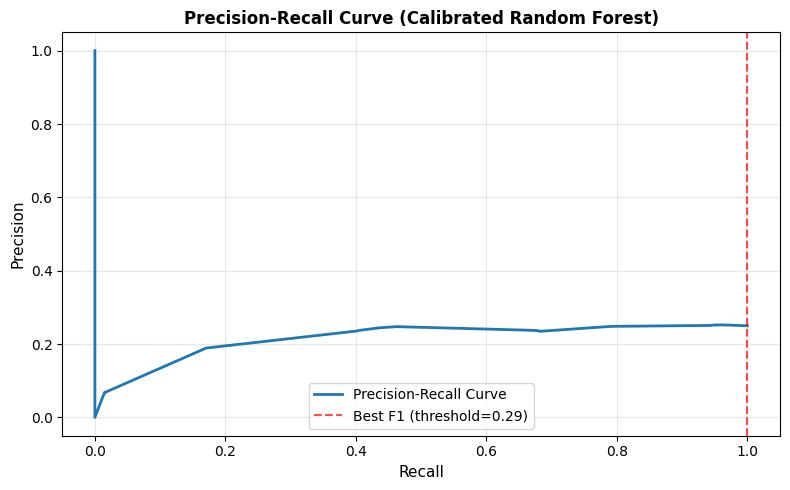


✓ Using profit-optimal threshold (0.05) for retention decisions


In [9]:
from sklearn.metrics import precision_recall_curve

# ===== PROFIT-OPTIMAL THRESHOLD =====
# Business assumption: 
#   - Cost to reach out to a customer: $1
#   - Expected saved revenue if we prevent churn: $10
COST = 1.0
BENEFIT = 10.0

thresholds = np.linspace(0.05, 0.95, 19)
profits = []

for t in thresholds:
    preds = (val_probs_rf_cal >= t).astype(int)
    tp = ((preds == 1) & (y_val == 1)).sum()  # Correctly identified churners
    fp = ((preds == 1) & (y_val == 0)).sum()  # False alarms
    profit = tp * BENEFIT - fp * COST
    profits.append(profit)

best_idx = int(np.argmax(profits))
best_t_profit = thresholds[best_idx]
best_profit = profits[best_idx]

print(f"\n{'='*70}")
print("PROFIT-OPTIMAL THRESHOLD")
print(f"{'='*70}")
print(f"Outreach Cost: ${COST:.2f} | Saved Revenue: ${BENEFIT:.2f}")
print(f"Optimal Threshold: {best_t_profit:.2f}")
print(f"Maximum Profit: ${best_profit:,.0f}")

# Show top 5 thresholds by profit
profit_df = pd.DataFrame({"threshold": thresholds, "profit": profits}).sort_values("profit", ascending=False)
print(f"\nTop 5 Thresholds by Profit:")
print(profit_df.head().to_string(index=False))

# ===== F1-OPTIMAL THRESHOLD =====
precision, recall, pr_thresholds = precision_recall_curve(y_val, val_probs_rf_cal)

# Avoid division by zero
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)

best_f1_idx = int(np.argmax(f1))
best_t_f1 = pr_thresholds[best_f1_idx] if best_f1_idx < len(pr_thresholds) else 0.5
best_f1 = f1[best_f1_idx]

print(f"\n{'='*70}")
print("F1-OPTIMAL THRESHOLD")
print(f"{'='*70}")
print(f"Optimal Threshold: {best_t_f1:.2f}")
print(f"Best F1 Score: {best_f1:.4f}")

# Visualize precision-recall curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, linewidth=2, label="Precision-Recall Curve")
plt.axvline(x=recall[best_f1_idx] if best_f1_idx < len(recall) else 0.5, 
            color="red", linestyle="--", alpha=0.7, label=f"Best F1 (threshold={best_t_f1:.2f})")
plt.xlabel("Recall", fontsize=11)
plt.ylabel("Precision", fontsize=11)
plt.title("Precision-Recall Curve (Calibrated Random Forest)", fontsize=12, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Using profit-optimal threshold ({best_t_profit:.2f}) for retention decisions")

## 9. Evaluation Metrics (ROC-AUC, PR-AUC, Lift, Gains)

Calculate ROC-AUC and PR-AUC (Average Precision) for imbalanced data. Compute lift and gains curves showing model performance at each percentile.


EVALUATION METRICS (Calibrated Random Forest)
ROC-AUC:                 0.4672
PR-AUC (Avg Precision):  0.2313
Baseline PR-AUC (random):0.2498
Improvement vs Baseline: 0.93x


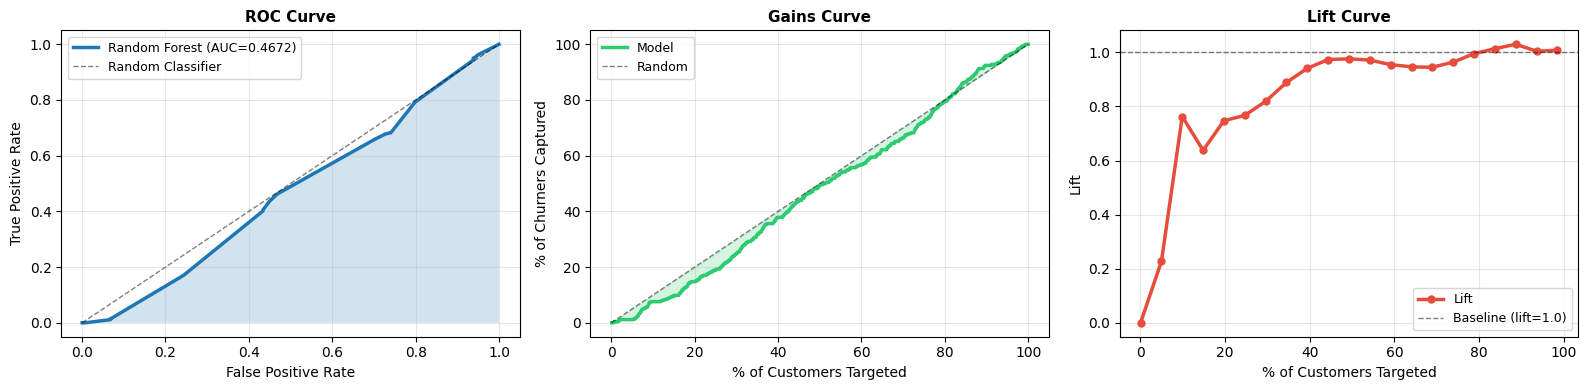


Lift at Key Percentiles:
Percentile   Lift       Churners Captured   
------------------------------------------
Top 10%         0.76x       7.6%
Top 20%         0.74x       14.8%
Top 30%         0.83x       25.0%


In [10]:
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve

# Calculate key metrics
pr_auc = average_precision_score(y_val, val_probs_rf_cal)
roc_auc = roc_auc_score(y_val, val_probs_rf_cal)
baseline_pr_auc = y_val.mean()  # Precision of random classifier

print(f"\n{'='*70}")
print("EVALUATION METRICS (Calibrated Random Forest)")
print(f"{'='*70}")
print(f"ROC-AUC:                 {roc_auc:.4f}")
print(f"PR-AUC (Avg Precision):  {pr_auc:.4f}")
print(f"Baseline PR-AUC (random):{baseline_pr_auc:.4f}")
print(f"Improvement vs Baseline: {pr_auc / baseline_pr_auc:.2f}x")

# Calculate ROC curve for visualization
fpr, tpr, _ = roc_curve(y_val, val_probs_rf_cal)

# Prepare gains data
val_sorted = val_df.copy()
val_sorted["churn_risk_score"] = val_probs_rf_cal
val_sorted = val_sorted.sort_values("churn_risk_score", ascending=False).reset_index(drop=True)

val_sorted["cumulative_customers"] = np.arange(1, len(val_sorted) + 1)
val_sorted["cumulative_churn"] = val_sorted["churned"].cumsum()
val_sorted["cumulative_pct_customers"] = val_sorted["cumulative_customers"] / len(val_sorted) * 100
val_sorted["cumulative_pct_churn"] = val_sorted["cumulative_churn"] / val_sorted["churned"].sum() * 100

# Lift: (churn rate in segment) / (overall churn rate)
overall_churn_rate = y_val.mean()
val_sorted["lift"] = (val_sorted["cumulative_churn"] / val_sorted["cumulative_customers"]) / overall_churn_rate

# Visualize ROC, Gains, and Lift curves
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# ROC Curve
axes[0].plot(fpr, tpr, linewidth=2.5, label=f"Random Forest (AUC={roc_auc:.4f})")
axes[0].plot([0, 1], [0, 1], "k--", linewidth=1, alpha=0.5, label="Random Classifier")
axes[0].fill_between(fpr, tpr, alpha=0.2)
axes[0].set_xlabel("False Positive Rate", fontsize=10)
axes[0].set_ylabel("True Positive Rate", fontsize=10)
axes[0].set_title("ROC Curve", fontsize=11, fontweight="bold")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Gains Curve
axes[1].plot(val_sorted["cumulative_pct_customers"], val_sorted["cumulative_pct_churn"], 
             linewidth=2.5, label="Model", color="#2ecc71")
axes[1].plot([0, 100], [0, 100], "k--", linewidth=1, alpha=0.5, label="Random")
axes[1].fill_between(val_sorted["cumulative_pct_customers"], val_sorted["cumulative_pct_churn"], 
                     val_sorted["cumulative_pct_customers"], alpha=0.2, color="#2ecc71")
axes[1].set_xlabel("% of Customers Targeted", fontsize=10)
axes[1].set_ylabel("% of Churners Captured", fontsize=10)
axes[1].set_title("Gains Curve", fontsize=11, fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# Lift Curve (sample every 5%)
sample_idx = np.arange(0, len(val_sorted), max(1, len(val_sorted) // 20))
axes[2].plot(val_sorted.loc[sample_idx, "cumulative_pct_customers"], 
             val_sorted.loc[sample_idx, "lift"], 
             "o-", linewidth=2.5, markersize=5, color="#e74c3c", label="Lift")
axes[2].axhline(y=1.0, color="k", linestyle="--", linewidth=1, alpha=0.5, label="Baseline (lift=1.0)")
axes[2].set_xlabel("% of Customers Targeted", fontsize=10)
axes[2].set_ylabel("Lift", fontsize=10)
axes[2].set_title("Lift Curve", fontsize=11, fontweight="bold")
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print lift at key percentiles
print(f"\nLift at Key Percentiles:")
print(f"{'Percentile':<12} {'Lift':<10} {'Churners Captured':<20}")
print("-" * 42)
for pct in [10, 20, 30]:
    idx = int(len(val_sorted) * pct / 100)
    lift_at_pct = val_sorted.loc[idx, "lift"]
    churn_captured = val_sorted.loc[idx, "cumulative_pct_churn"]
    print(f"Top {pct}%{'':<8} {lift_at_pct:.2f}x{'':<6} {churn_captured:.1f}%")

## 10. Top-N Targeting Performance

Evaluate retention campaign effectiveness by targeting top N% highest-risk customers. Report precision, recall, and lift at common percentiles.


TOP-N TARGETING PERFORMANCE (Retention Campaign Efficiency)
 top_n_pct  customers_targeted  churners_found  precision   recall     lift
         5                  52               3   0.057692 0.011364 0.230988
        10                 105              20   0.190476 0.075758 0.762626
        15                 158              25   0.158228 0.094697 0.633511
        20                 211              39   0.184834 0.147727 0.740037
        25                 264              50   0.189394 0.189394 0.758293
        30                 317              65   0.205047 0.246212 0.820966

📊 KEY INSIGHTS:
  • Top 10% targeting finds 20 churners (lift: 0.8x baseline)
  • Top 20% targeting captures 14.8% of all churners


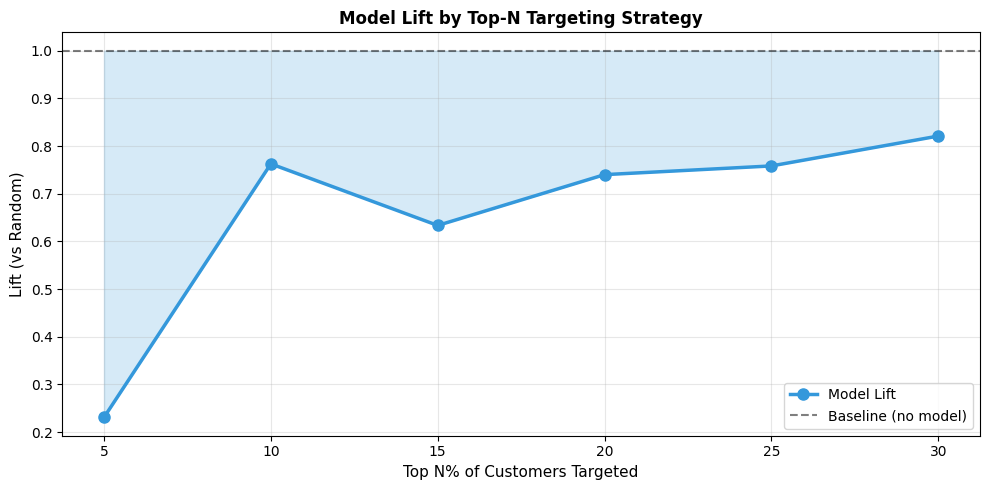

In [11]:
# Evaluate targeting performance at different percentiles
top_n_results = []

for n_pct in [5, 10, 15, 20, 25, 30]:
    n_customers = int(len(val_sorted) * n_pct / 100)
    top_n = val_sorted.head(n_customers)
    
    # Metrics
    actual_churners = top_n["churned"].sum()
    precision = top_n["churned"].mean()
    recall = actual_churners / val_sorted["churned"].sum()
    lift = precision / overall_churn_rate
    
    top_n_results.append({
        "top_n_pct": n_pct,
        "customers_targeted": n_customers,
        "churners_found": actual_churners,
        "precision": precision,
        "recall": recall,
        "lift": lift
    })

top_n_df = pd.DataFrame(top_n_results)

print(f"\n{'='*70}")
print("TOP-N TARGETING PERFORMANCE (Retention Campaign Efficiency)")
print(f"{'='*70}")
print(top_n_df.to_string(index=False))

# Interpret results
print(f"\n📊 KEY INSIGHTS:")
print(f"  • Top 10% targeting finds {top_n_df.iloc[1]['churners_found']:.0f} churners " + 
      f"(lift: {top_n_df.iloc[1]['lift']:.1f}x baseline)")
print(f"  • Top 20% targeting captures {top_n_df.iloc[3]['recall']:.1%} of all churners")

# Visualize lift by percentile
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(top_n_df["top_n_pct"], top_n_df["lift"], "o-", linewidth=2.5, markersize=8, 
        color="#3498db", label="Model Lift")
ax.axhline(y=1.0, color="k", linestyle="--", linewidth=1.5, alpha=0.5, label="Baseline (no model)")
ax.fill_between(top_n_df["top_n_pct"], top_n_df["lift"], 1.0, alpha=0.2, color="#3498db")
ax.set_xlabel("Top N% of Customers Targeted", fontsize=11)
ax.set_ylabel("Lift (vs Random)", fontsize=11)
ax.set_title("Model Lift by Top-N Targeting Strategy", fontsize=12, fontweight="bold")
ax.set_xticks(top_n_df["top_n_pct"])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Feature Importance (Coefficients & Permutation)

Extract logistic regression coefficients and Random Forest feature importances. Identify key drivers of churn predictions.


FEATURE IMPORTANCE ANALYSIS

1. LOGISTIC REGRESSION COEFFICIENTS
----------------------------------------------------------------------


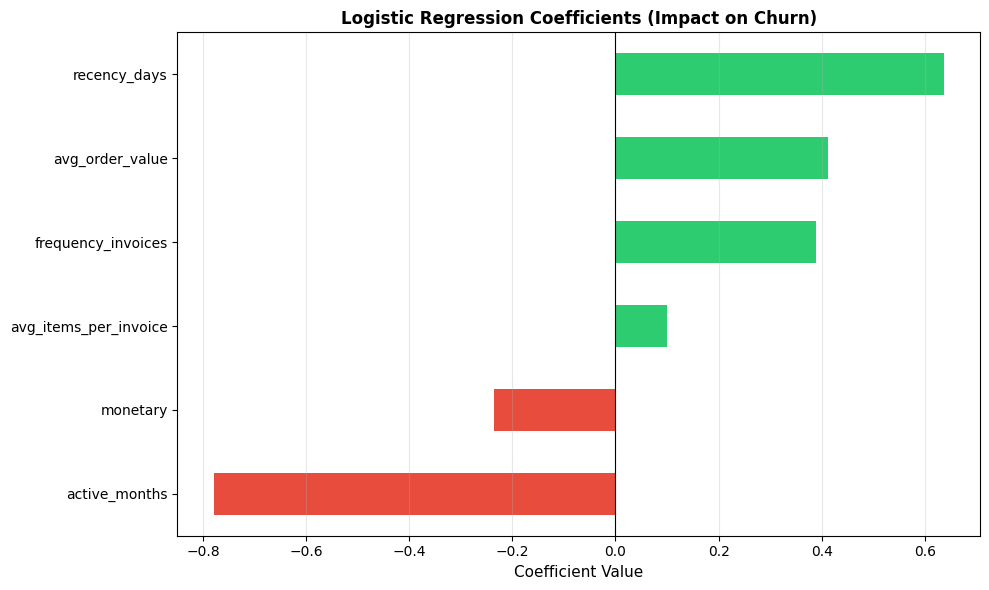


Top 5 Features Increasing Churn Risk (Positive Coefficients):
recency_days             0.635991
avg_order_value          0.412441
frequency_invoices       0.388195
avg_items_per_invoice    0.099831
monetary                -0.235472

Top 5 Features Decreasing Churn Risk (Negative Coefficients):
active_months           -0.778468
monetary                -0.235472
avg_items_per_invoice    0.099831
frequency_invoices       0.388195
avg_order_value          0.412441


2. RANDOM FOREST FEATURE IMPORTANCE
----------------------------------------------------------------------


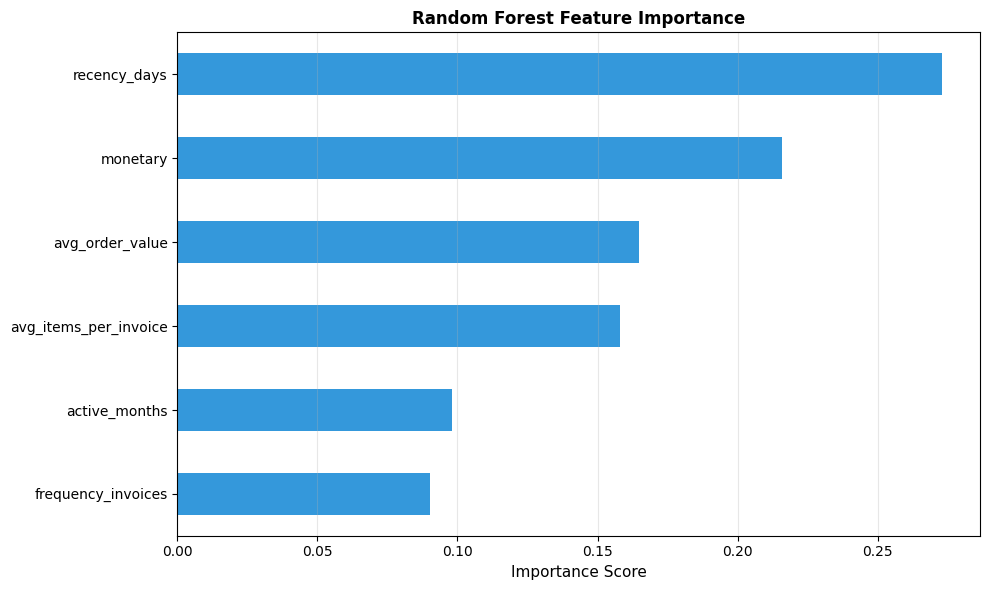


Top 10 Features by Importance:
recency_days             0.272944
monetary                 0.215899
avg_order_value          0.164923
avg_items_per_invoice    0.158004
active_months            0.097946
frequency_invoices       0.090285


3. PERMUTATION IMPORTANCE (Validation Set)
----------------------------------------------------------------------
Computing permutation importance (this may take a minute)...


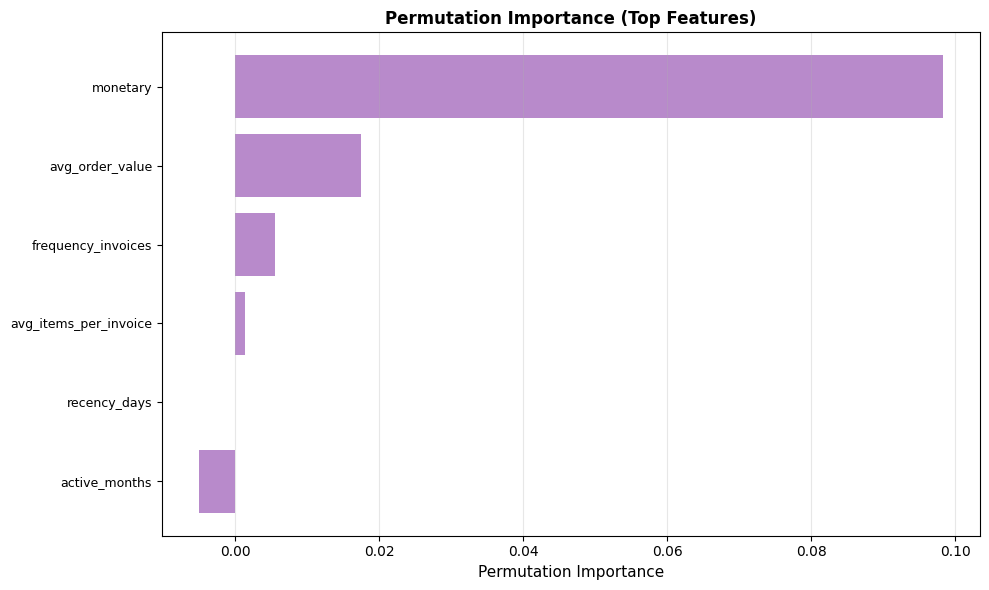


Top 10 Features by Permutation Importance:
monetary                 0.098297
avg_order_value          0.017502
frequency_invoices       0.005582
avg_items_per_invoice    0.001325
recency_days             0.000000
active_months           -0.005014


In [12]:
from sklearn.inspection import permutation_importance

print(f"\n{'='*70}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*70}")

# ===== LOGISTIC REGRESSION COEFFICIENTS =====
print("\n1. LOGISTIC REGRESSION COEFFICIENTS")
print("-" * 70)
coef = pd.Series(log_reg.named_steps["clf"].coef_[0], index=num_cols).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
coef.plot(kind="barh", ax=ax, color=["#e74c3c" if x < 0 else "#2ecc71" for x in coef.values])
ax.set_xlabel("Coefficient Value", fontsize=11)
ax.set_title("Logistic Regression Coefficients (Impact on Churn)", fontsize=12, fontweight="bold")
ax.axvline(x=0, color="k", linestyle="-", linewidth=0.8)
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 Features Increasing Churn Risk (Positive Coefficients):")
print(coef.sort_values(ascending=False).head(5).to_string())
print("\nTop 5 Features Decreasing Churn Risk (Negative Coefficients):")
print(coef.sort_values().head(5).to_string())

# ===== RANDOM FOREST FEATURE IMPORTANCE =====
print("\n\n2. RANDOM FOREST FEATURE IMPORTANCE")
print("-" * 70)
rf_importance = pd.Series(rf.feature_importances_, index=num_cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
rf_importance.plot(kind="barh", ax=ax, color="#3498db")
ax.set_xlabel("Importance Score", fontsize=11)
ax.set_title("Random Forest Feature Importance", fontsize=12, fontweight="bold")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Features by Importance:")
print(pd.Series(rf.feature_importances_, index=num_cols).sort_values(ascending=False).head(10).to_string())

# ===== PERMUTATION IMPORTANCE =====
print("\n\n3. PERMUTATION IMPORTANCE (Validation Set)")
print("-" * 70)
print("Computing permutation importance (this may take a minute)...")

result = permutation_importance(
    rf, X_val[num_cols], y_val, n_repeats=10, random_state=42, n_jobs=-1
)

perm_importance = pd.Series(result.importances_mean, index=num_cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(np.arange(len(perm_importance)), perm_importance.values, color="#9b59b6", alpha=0.7)
ax.set_yticks(np.arange(len(perm_importance)))
ax.set_yticklabels(perm_importance.index, fontsize=9)
ax.set_xlabel("Permutation Importance", fontsize=11)
ax.set_title("Permutation Importance (Top Features)", fontsize=12, fontweight="bold")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Features by Permutation Importance:")
print(perm_importance.sort_values(ascending=False).head(10).to_string())

## 12. SHAP Explainability Analysis

Use SHAP TreeExplainer to compute feature contributions and visualize global feature impact on churn risk.

In [13]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



SHAP EXPLAINABILITY ANALYSIS
Computing SHAP values (this may take a moment)...


<Figure size 1000x600 with 0 Axes>

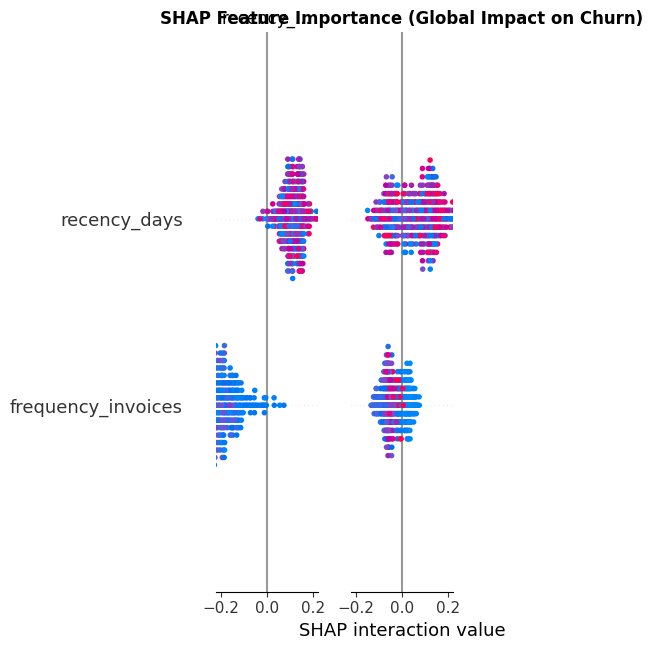

<Figure size 1000x800 with 0 Axes>

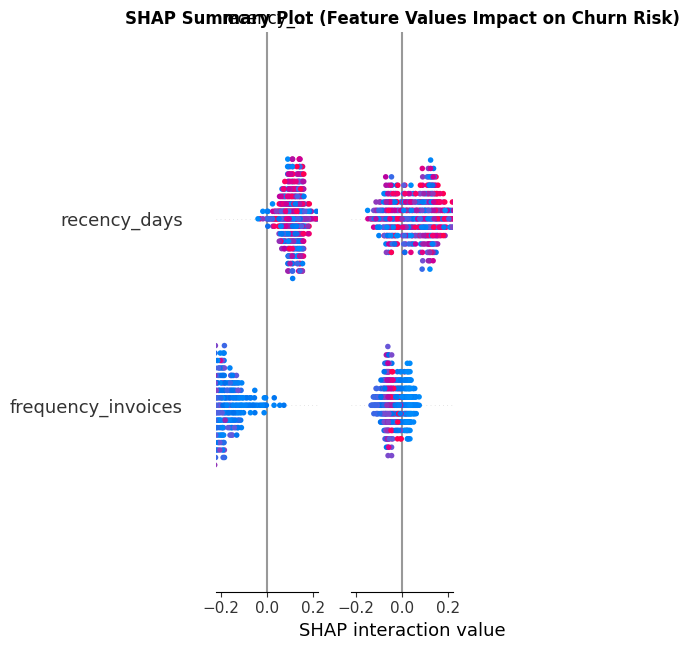


✓ SHAP analysis complete


In [17]:
try:
    import shap
    
    print(f"\n{'='*70}")
    print("SHAP EXPLAINABILITY ANALYSIS")
    print(f"{'='*70}")
    print("Computing SHAP values (this may take a moment)...")
    
    # Use sample for speed
    X_val_sample = X_val[num_cols].sample(n=min(500, len(X_val)), random_state=42)
    
    # TreeExplainer for Random Forest
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_val_sample)
    
    # For binary classification with newer SHAP versions:
    # shap_values is a list [class0_shap, class1_shap]
    # For older versions, it might be just the positive class
    if isinstance(shap_values, list):
        shap_churn = shap_values[1]  # Class 1 (churn)
    else:
        shap_churn = shap_values
    
    # Summary Plot (Bar) - Global feature importance
    fig = plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_churn, X_val_sample, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Global Impact on Churn)", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()
    
    # Summary Plot (Dot) - Feature values and impact
    fig = plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_churn, X_val_sample, show=False)
    plt.title("SHAP Summary Plot (Feature Values Impact on Churn Risk)", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()
    
    print("\n✓ SHAP analysis complete")
    
except ImportError:
    print("\n⚠ SHAP library not found. Install with: pip install shap")
except Exception as e:
    print(f"\n⚠ Error calculating SHAP values: {type(e).__name__}: {e}")

## 13. Retention Policy (Churn Risk × CLV Priority Score)

Combine calibrated churn risk with customer lifetime value (CLV) to create a business-driven priority score. Assign recommended retention actions based on risk and value thresholds.

Generating churn risk scores for all customers...
Churn Risk Score Summary:
count    5281.000000
mean        0.573012
std         0.174608
min         0.287426
25%         0.423070
50%         0.463226
75%         0.777151
max         0.805279
Name: churn_risk, dtype: float64

Loading CLV data: 5,281 customers

RETENTION POLICY: CHURN RISK × CLV PRIORITY SCORE

Retention policy applied to 5,281 customers

TOP 15 PRIORITY CUSTOMERS:
 customer_id                 cluster_name  churn_risk       clv_12m  priority_score   recommended_action
       18102 Inactive / At-Risk Customers    0.490324 225719.179793   110675.630441 🔵 MONITOR (Low Risk)
       14646 Inactive / At-Risk Customers    0.472105 200001.318498    94421.618141 🔵 MONITOR (Low Risk)
       14156 Inactive / At-Risk Customers    0.472105 138135.963805    65214.676202 🔵 MONITOR (Low Risk)
       17450 Inactive / At-Risk Customers    0.472105 110279.463420    52063.483691 🔵 MONITOR (Low Risk)
       14911 Inactive / At-Risk Custome

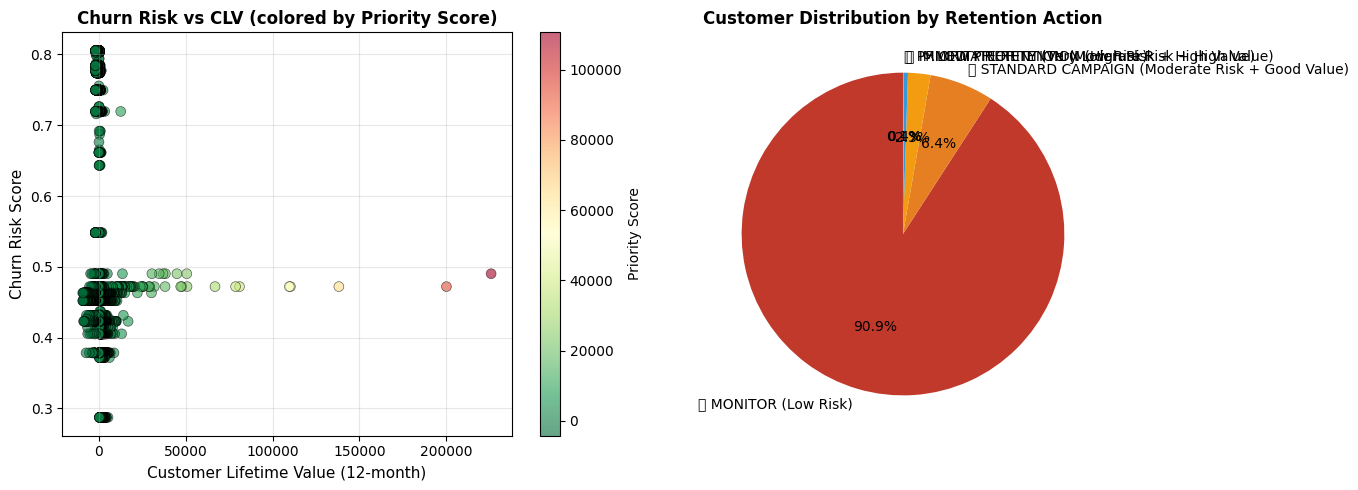

In [18]:
# Generate churn risk scores for all customers
print("Generating churn risk scores for all customers...")
X_all = churn_df.drop(columns=["customer_id", "churned", "last_purchase"])
churn_df["churn_risk"] = cal_rf.predict_proba(X_all[num_cols])[:, 1]

print(f"Churn Risk Score Summary:")
print(churn_df["churn_risk"].describe())

# Now load CLV to combine with churn risk
try:
    segments_clv = pd.read_csv(DATA_DIR / "customer_segments_with_clv.csv")
    
    print(f"\nLoading CLV data: {len(segments_clv):,} customers")
    
    # Merge churn risk + CLV
    retention_df = churn_df[["customer_id", "churn_risk"]].merge(
        segments_clv[["customer_id", "clv_12m", "cluster_name"]], 
        on="customer_id", 
        how="left"
    )
    
    # Fill missing CLV with 0
    retention_df["clv_12m"] = retention_df["clv_12m"].fillna(0)
    
    # Priority score: churn_risk × CLV
    # Higher score = higher risk AND higher value
    retention_df["priority_score"] = retention_df["churn_risk"] * retention_df["clv_12m"]
    
    # Normalize priority score to 0-100
    if retention_df["priority_score"].max() > 0:
        retention_df["priority_score_norm"] = (
            (retention_df["priority_score"] - retention_df["priority_score"].min()) /
            (retention_df["priority_score"].max() - retention_df["priority_score"].min()) * 100
        )
    else:
        retention_df["priority_score_norm"] = 0
    
    # Define retention action thresholds
    def assign_action(row):
        if pd.isna(row["clv_12m"]) or row["clv_12m"] == 0:
            return "No CLV data"
        
        clv_75th = retention_df["clv_12m"].quantile(0.75)
        clv_50th = retention_df["clv_12m"].quantile(0.50)
        
        if row["churn_risk"] >= 0.7 and row["clv_12m"] >= clv_75th:
            return "🔴 IMMEDIATE RETENTION (High Risk + High Value)"
        elif row["churn_risk"] >= 0.5 and row["clv_12m"] >= clv_75th:
            return "🟠 PRIORITY RETENTION (Moderate Risk + High Value)"
        elif row["churn_risk"] >= 0.5 and row["clv_12m"] >= clv_50th:
            return "🟡 STANDARD CAMPAIGN (Moderate Risk + Good Value)"
        elif row["churn_risk"] >= 0.3:
            return "🔵 MONITOR (Low Risk)"
        else:
            return "⚪ LOW PRIORITY (Very Low Risk)"
    
    retention_df["recommended_action"] = retention_df.apply(assign_action, axis=1)
    
    # Sort by priority score (highest first)
    retention_df = retention_df.sort_values("priority_score", ascending=False)
    
    print(f"\n{'='*70}")
    print("RETENTION POLICY: CHURN RISK × CLV PRIORITY SCORE")
    print(f"{'='*70}")
    print(f"\nRetention policy applied to {len(retention_df):,} customers\n")
    
    print("TOP 15 PRIORITY CUSTOMERS:")
    display_cols = ["customer_id", "cluster_name", "churn_risk", "clv_12m", "priority_score", "recommended_action"]
    print(retention_df[display_cols].head(15).to_string(index=False))
    
    # Summary by action
    print(f"\n{'='*70}")
    print("RETENTION ACTIONS SUMMARY")
    print(f"{'='*70}\n")
    action_summary = retention_df.groupby("recommended_action").agg(
        customers=("customer_id", "count"),
        avg_churn_risk=("churn_risk", "mean"),
        avg_clv=("clv_12m", "mean"),
        total_clv=("clv_12m", "sum")
    ).sort_values("total_clv", ascending=False)
    
    # Format for better readability
    action_summary["avg_churn_risk"] = action_summary["avg_churn_risk"].map("{:.2%}".format)
    action_summary["avg_clv"] = action_summary["avg_clv"].map("${:,.0f}".format)
    action_summary["total_clv"] = action_summary["total_clv"].map("${:,.0f}".format)
    
    print(action_summary.to_string())
    
    # Visualize priority distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Churn Risk vs CLV scatter
    scatter = axes[0].scatter(retention_df["clv_12m"], retention_df["churn_risk"], 
                              c=retention_df["priority_score"], cmap="RdYlGn_r", 
                              alpha=0.6, s=50, edgecolors="black", linewidth=0.5)
    axes[0].set_xlabel("Customer Lifetime Value (12-month)", fontsize=11)
    axes[0].set_ylabel("Churn Risk Score", fontsize=11)
    axes[0].set_title("Churn Risk vs CLV (colored by Priority Score)", fontsize=12, fontweight="bold")
    axes[0].grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=axes[0])
    cbar.set_label("Priority Score", fontsize=10)
    
    # Actions breakdown
    action_counts = retention_df["recommended_action"].value_counts()
    colors_pie = ["#c0392b", "#e67e22", "#f39c12", "#3498db", "#95a5a6"]
    axes[1].pie(action_counts.values, labels=action_counts.index, autopct="%1.1f%%", 
                colors=colors_pie[:len(action_counts)], startangle=90)
    axes[1].set_title("Customer Distribution by Retention Action", fontsize=12, fontweight="bold")
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print(f"\n⚠ CLV data not found at {DATA_DIR / 'customer_segments_with_clv.csv'}")
    print("Run notebook 03_rfi_analysis.ipynb first to generate CLV calculations")
    retention_df = None
except Exception as e:
    print(f"\n⚠ Error loading CLV data: {e}")
    retention_df = None

## 14. Save Model Artifacts and Predictions

Export calibrated model, logistic regression, and Random Forest to pickle files. Save churn risk scores and retention policy recommendations to CSV for dashboard integration.

In [19]:
import joblib

print(f"\n{'='*70}")
print("SAVING MODEL ARTIFACTS AND PREDICTIONS")
print(f"{'='*70}\n")

# Save models
joblib.dump(cal_rf, MODELS_DIR / "churn_rf_calibrated.pkl")
print(f"✓ Saved: {MODELS_DIR / 'churn_rf_calibrated.pkl'}")

joblib.dump(log_reg, MODELS_DIR / "churn_logreg.pkl")
print(f"✓ Saved: {MODELS_DIR / 'churn_logreg.pkl'}")

joblib.dump(rf, MODELS_DIR / "churn_rf.pkl")
print(f"✓ Saved: {MODELS_DIR / 'churn_rf.pkl'}")

# Save numeric columns list (needed for predictions)
joblib.dump(num_cols, MODELS_DIR / "churn_model_features.pkl")
print(f"✓ Saved: {MODELS_DIR / 'churn_model_features.pkl'}")

# Save churn risk scores
churn_df[["customer_id", "churn_risk"]].to_csv(DATA_DIR / "customer_churn_risk.csv", index=False)
print(f"✓ Saved: {DATA_DIR / 'customer_churn_risk.csv'} ({len(churn_df):,} customers)")

# Save retention policy (if CLV was available)
if retention_df is not None:
    retention_df[["customer_id", "churn_risk", "clv_12m", "priority_score", 
                  "priority_score_norm", "cluster_name", "recommended_action"]].to_csv(
        DATA_DIR / "customer_retention_policy.csv", index=False
    )
    print(f"✓ Saved: {DATA_DIR / 'customer_retention_policy.csv'} ({len(retention_df):,} customers)")
else:
    print("⚠ Retention policy not saved (CLV data not available)")

print(f"\n{'='*70}")
print("MODEL SUMMARY")
print(f"{'='*70}")
print(f"Best Model: Calibrated Random Forest")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"Validation Set Size: {len(val_df):,} customers")
print(f"Churn Prediction Threshold (Profit-Optimal): {best_t_profit:.2f}")
print(f"\nReady for deployment! Use customer_churn_risk.csv for dashboard/API.")
print(f"{'='*70}")


SAVING MODEL ARTIFACTS AND PREDICTIONS

✓ Saved: d:\Projects\Retail_Customer_Intelligence\models\churn_rf_calibrated.pkl
✓ Saved: d:\Projects\Retail_Customer_Intelligence\models\churn_logreg.pkl
✓ Saved: d:\Projects\Retail_Customer_Intelligence\models\churn_rf.pkl
✓ Saved: d:\Projects\Retail_Customer_Intelligence\models\churn_model_features.pkl
✓ Saved: d:\Projects\Retail_Customer_Intelligence\data\processed\customer_churn_risk.csv (5,281 customers)
✓ Saved: d:\Projects\Retail_Customer_Intelligence\data\processed\customer_retention_policy.csv (5,281 customers)

MODEL SUMMARY
Best Model: Calibrated Random Forest
ROC-AUC: 0.4672
PR-AUC: 0.2313
Validation Set Size: 1,057 customers
Churn Prediction Threshold (Profit-Optimal): 0.05

Ready for deployment! Use customer_churn_risk.csv for dashboard/API.
